In [1488]:
import diffusion
from get_embedding import get_embedding

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap


import os
import glob
import random
import multiprocessing as mp
import itertools


#from velocity_plot import velocity_plot as vpl
#from sampling import *
#from colormap import *

In [3]:
detail_result_path = '/Users/pengzhizhang/Documents/test_data/Gastrulation/velocity_result'
output_path = detail_result_path
raw_data_path = '/Users/pengzhizhang/Documents/test_data/Gastrulation/raw_data'

In [4]:
load_raw_data = pd.read_csv(os.path.join(raw_data_path, 'mouse_endo_blood20to25_2000_genes_moment100.csv'))

In [5]:
detail_files = glob.iglob(os.path.join(detail_result_path, 'result_detailcsv/*/*/detail*.csv'))
lcd = list()
for f in detail_files:
    load_cellDancer_temp = pd.read_csv(f)
    load_cellDancer_temp.rename(columns = {'Unnamed: 0':'cellIndex'}, inplace = True)
    load_cellDancer_temp = load_cellDancer_temp.sort_values(by = ['gene_name', 'cellIndex'], ascending = [True, True])
    lcd.append(load_cellDancer_temp)
load_cellDancer = pd.concat(lcd)

In [312]:
gene_choice=list(set(load_cellDancer.gene_name))
n_neighbors=100
step=(60,60)

embedding, sampling_ixs, velocity_embedding = get_embedding(
    load_raw_data=load_raw_data, 
    load_cellDancer=load_cellDancer, 
    gene_list=gene_choice,
    mode="gene",
    n_neighbors=n_neighbors,
    step=step)

neighbors
tranfer mode: None
None
using gene mode
(2000, 12329)
(2000, 12329)


/Users/pengzhizhang/cellDancer-activate/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


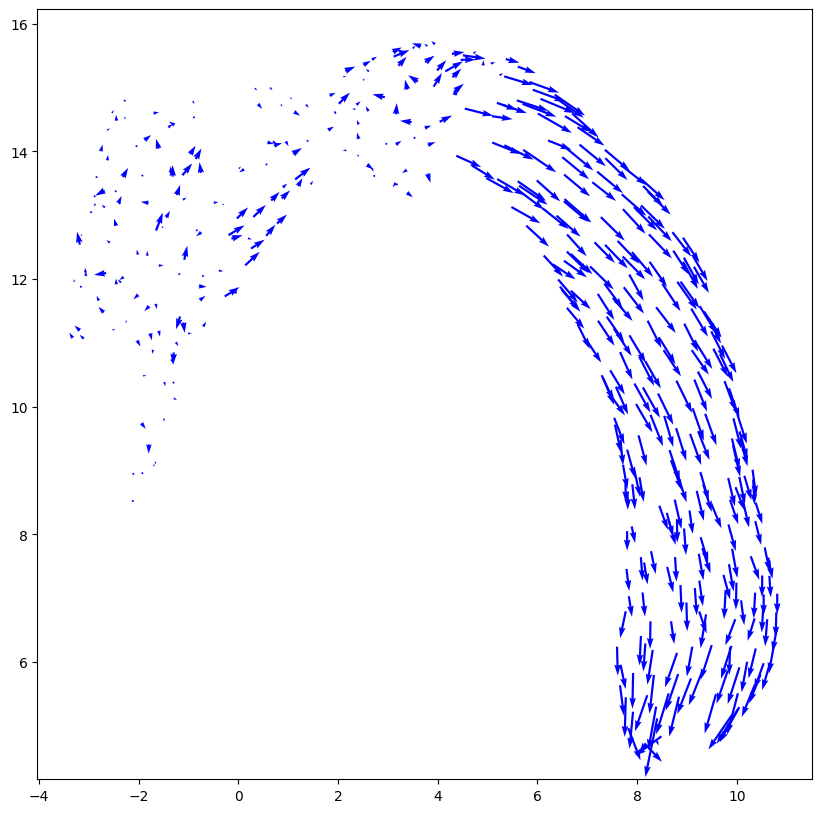

In [538]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.scatter(embedding[:, 0],embedding[:, 1], c="Silver", s=5, alpha=1)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1], color='Blue')
plt.show()

In [316]:
def gaussian_kernel(X, mu=0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [446]:
def embedding_normalization(cell_embedding, embedding=None, mode="minmax", NORM_ALL_CELLS=False):
    '''
    Normalize by the maximum absolute value.
    
    Parameters
    ----------
    embedding: 2D numpy array (n_cells, 2)
    
    mode: 'maxabs', "minmax", "norm"
    
    
    maxabs is meant for sparse data and/or centered at 0. 
    (a must for velocity normalization)
    
    (???)
    Note in this program, it is pretty safe to do maxabs normalization
    since the data are free of extreme outliers.
     
    '''
    if mode in ['max', 'maximum', 'maxabs']:
        transformer = preprocessing.MaxAbsScaler().fit(cell_embedding)
    elif mode in ['minmax']:
        transformer = preprocessing.MinMaxScaler().fit(cell_embedding)
    em = transformer.transform(cell_embedding)
    if NORM_ALL_CELLS:
        em_all = transformer.transform(embedding)
        return em, em_all
    else:
        return em
    
cell_embedding, normalized_embedding = embedding_normalization(
    embedding[sampling_ixs], embedding, mode='minmax', NORM_ALL_CELLS=True)
velocity = embedding_normalization(velocity_embedding, mode='max')

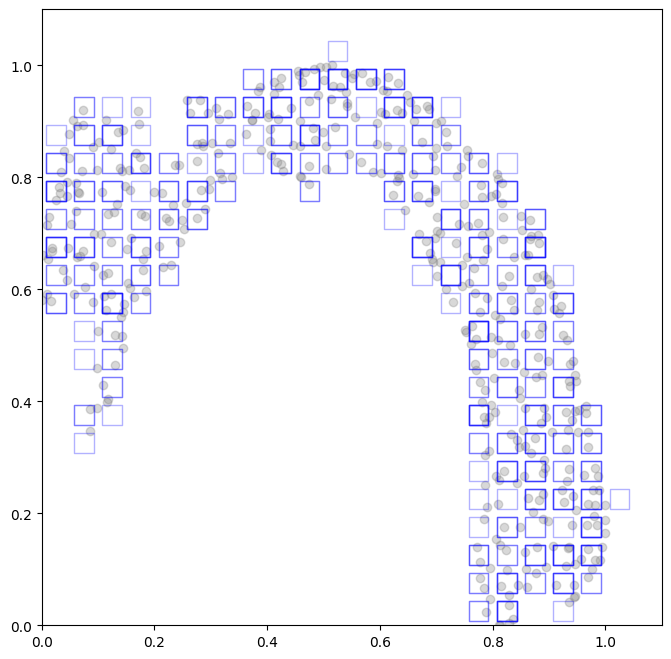

In [1560]:
#np.seterr(divide='ignore', invalid='ignore')
def discretize(coordinate, xmin, xmax, steps, capping=False):
    '''
    '''
    grid_size = np.array(xmax) - np.array(xmin)
    grid_size = grid_size / np.array(steps)

    grid_idx = np.int64(np.floor((coordinate-xmin)/grid_size))
    
    if capping:
        grid_idx = np.where(grid_idx > steps, steps, grid_idx)
        grid_idx = np.where(grid_idx <0, 0, grid_idx)
    
    grid_coor = xmin + grid_size * (grid_idx+0.5)
    return grid_idx, grid_coor 

def totuple(arr):
    try:
        return tuple(totuple(i) for i in arr)
    except TypeError:
        return arr

def generate_grid(cell_embedding, embedding, velocity_embedding, steps):
    '''
    the original embedding is used to generate the density
    '''
    xmin = np.min(cell_embedding, axis=0)
    xmax = np.max(cell_embedding, axis=0)
    steps = np.array(steps, dtype=int)

    cell_grid_idx, cell_grid_coor = discretize(cell_embedding, xmin=xmin, xmax=xmax, steps=steps)
    mesh = np.zeros(np.append(steps+1,len(steps)))

    # The actual steps need to allow a leeway +1 in each dimension.
    cnt = np.zeros(steps+1)
    
    for index in range(cell_grid_idx.shape[0]):
        grid_index = cell_grid_idx[index]
        if np.any(grid_index > steps) or np.any(grid_index < 0):
            continue
        grid_index = totuple(grid_index)
        mesh[grid_index] += velocity[index]
        cnt[grid_index] += 1
    cnt = cnt[:,:,None]
    mesh = np.divide(mesh, cnt, out=np.zeros_like(mesh), where=cnt!=0)
    
    
    
    #sanity check
    fig, ax = plt.subplots(figsize=(8, 8))

    plt.scatter(cell_embedding[:,0],cell_embedding[:,1], c='grey', alpha = 0.3)
    plt.scatter(cell_grid_coor[:,0], cell_grid_coor[:,1], marker='s', color='none', edgecolor='blue', s=200, alpha=0.3)
    plt.xlim([0,1.1])
    plt.ylim([0,1.1])
    plt.show()
    
    
    
    
    # The actual steps need to allow a leeway +1 in each dimension.
    density = np.zeros(steps+1)
    all_grid_idx, all_grid_coor = discretize(embedding, xmin=xmin, xmax=xmax, steps=steps)
    for index in range(all_grid_idx.shape[0]):
        all_grid_index = all_grid_idx[index]
        
        # outside density is not needed.
        if np.any(all_grid_index > steps) or np.any(all_grid_index < 0):
            continue
        all_grid_index = totuple(all_grid_index)
        density[all_grid_index] += 1
    return mesh, density, cell_grid_idx, cell_grid_coor, all_grid_idx, all_grid_coor

vel_mesh, grid_density, cell_grid_idx, cell_grid_coor, all_grid_idx, all_grid_coor \
= generate_grid(cell_embedding, normalized_embedding, velocity, steps=(20,20))

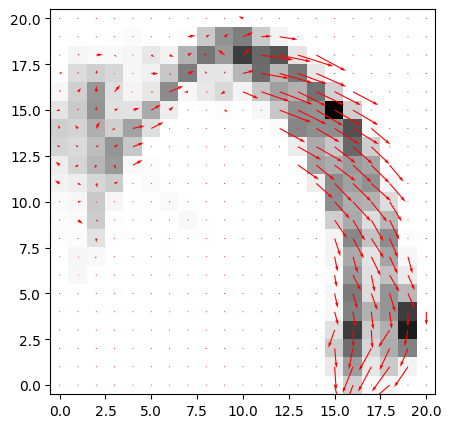

In [815]:
# sanity check
# support 2D only
def plot_mesh_velocity(mesh):
    x=list()
    y=list()
    vx=list()
    vy=list()
    for i in range(mesh.shape[0]):
        for j in range(mesh.shape[1]):
            x.append(i)
            y.append(j)
            vx.append(mesh[i,j][0])
            vy.append(mesh[i,j][1])
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.quiver(x,y,vx,vy,color='red',scale = 10)

plot_mesh_velocity(vel_mesh)
plt.rcParams['figure.figsize']=(5,5)
plt.imshow(grid_density.T, interpolation=None, origin='lower',cmap="Greys")
mpl.rcParams.update(mpl.rcParamsDefault)

In [481]:
def velocity_add_random(velocity, theta):
    '''
    Rotate the velocity according to a randomized kicks on the perpendicular direction.
    The direction is determined by the sign of a random number. 
    The magnitude of the perpendicular kick is determined by the random number 
    from a normal distribution N(0, theta).
    Magnitude of the velocity is kept the same to conserve energy (temperature) of the system.
    
    Parameters
    ----------
    velocity
        velocity of the grid
    theta
        the angular range that the noise could be affecting the direction of the velocity
        
    WARNING
        at a rare chance, the rotation angle (magnitude) could be much larger than theta.
        
    Return
    ------
    Adjusted velocity for the interested cell
        
    '''
    r = np.random.normal(0, theta, 1)
    cosine = np.cos(r)[0]
    sine = np.sin(r)[0]
    
    # Rotation matrix
    R = np.array([[cosine, sine],[-sine, cosine]])
    velocity = np.dot(velocity, R)
    return velocity

velocity_add_random(np.array([1,1]), np.pi/6)

array([0.56485853, 1.29650871])

In [483]:
def velocity_rotation(velocity, theta):
    '''
    Rotate the velocity clockwise by angle theta
    
    Parameters
    ----------
    velocity
        velocity of the grid
    theta
        the angular range that the noise could be affecting the direction of the velocity
        
    Return
    ------
    Adjusted velocity for the interested cell
        
    '''
    cosine = np.cos(theta)
    sine = np.sin(theta)
    
    # Rotation matrix
    R = np.array([[cosine, sine],[-sine, cosine]])
    velocity = np.dot(velocity, R)
    return velocity

velocity_rotation(np.array([1,1]), np.pi/6)

array([0.3660254, 1.3660254])

Trajectory stops at  1064 time steps.


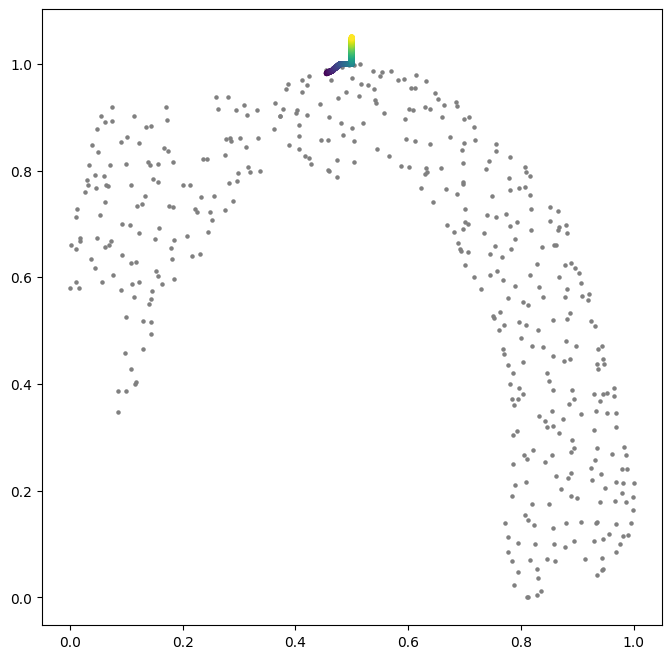

In [841]:
def diffusion_off_grid_wallbound(cell_embedding, vel, init, grid_density, dt=0.01, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), the cell's velocity will turn 90 degrees
    if it hits the boundary the next timestep.
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    grid_density
        Density for cell turning / stopping
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    #from collections import deque

    # TODO: recommmend values of dt and timestep
    THETA = np.pi/6
    
    XMIN = np.min(cell_embedding, axis=0)
    XMAX = np.max(cell_embedding, axis=0)
    STEPS=(vel.shape[0]-1,vel.shape[1]-1)
    
    
    def NextEmpty(xcur, xcur_d, vcur):
        xnxt = xcur + vcur*dt
        xnxt_d, dummy = discretize(xnxt, xmin=XMIN, xmax=XMAX, steps=STEPS)
        try:
            density = grid_density[xnxt_d[0], xnxt_d[1]]
        except IndexError:
            #if np.any(np.abs(xnxt_d-xcur_d)>3):
            #    print("Error: from ", xcur_d, "to out of box", xnxt_d, "in one step.")
            #    print("Consider to decrease dt and restart!")
            return True
        return density < 1
   
    x0 = init
    x0_d, dummy = discretize(x0, xmin=XMIN, xmax=XMAX, steps=STEPS)
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, THETA)
    trajectory = [x0]
    
    for i in range(t_total):
    
        if np.linalg.norm(v0) < eps:
            #print("Velocity is too small")
            return np.array(trajectory)
        if NextEmpty(x0, x0_d, v0):
            v0_cc = velocity_rotation(v0, np.pi/2)
            v0_c = velocity_rotation(v0, -np.pi/2)
            # nowhere to go but null
            CC = NextEmpty(x0, x0_d, v0_cc) 
            C = NextEmpty(x0, x0_d, v0_c)
            if CC and C:
                return np.array(trajectory)
            elif not C:
                v0 = v0_c
            else:
                v0 = v0_cc
                
        else:
            x = x0 + v0*dt
            x_d, dummy = discretize(x, xmin=XMIN, xmax=XMAX, steps=STEPS)
            try:
                v = vel[x_d[0],x_d[1]]
                density = grid_density[x_d[0],x_d[1]]
                v = velocity_add_random(v, THETA)
            except IndexError:
                #if np.any(np.abs(x_d-x0_d)>3):
                #    print("Error: from ", x0_d, "to out of box", x_d, "in one step.")
                #    print("Consider to decrease dt and restart!")
                break
            
            trajectory.append(x)
            x0 = x
            v0 = v

    return np.array(trajectory)

traj=diffusion_off_grid_wallbound(
    cell_embedding = cell_embedding, 
    vel = vel_mesh,
    init = cell_embedding[0], 
    dt = 0.001, 
    t_total = 10000, 
    grid_density = grid_density, 
    eps = 1e-6)

fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='gray', s=5)
plt.scatter(traj[:,0], traj[:,1], s=10, c=range(len(traj)))
print("Trajectory stops at ", len(traj), "time steps.")

Velocity is too small
Trajectory stops at  15 time steps.


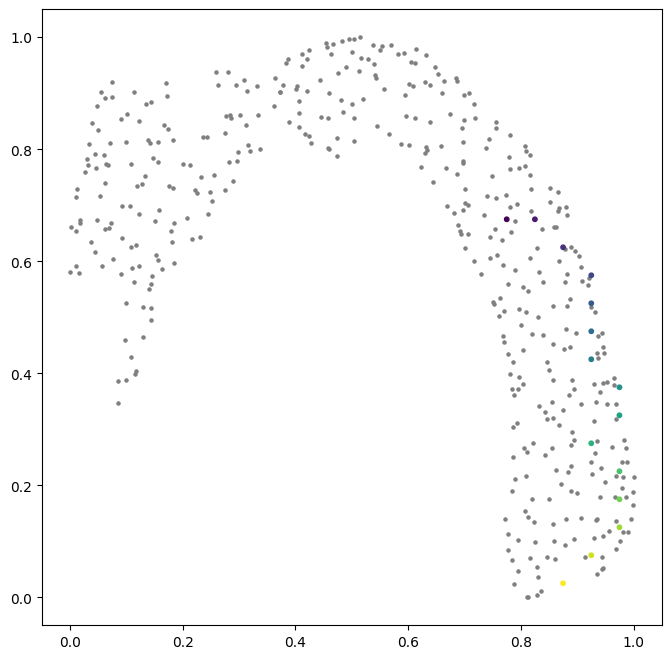

In [677]:
def diffusion_on_grid_wallbound(cell_embedding, vel, init, grid_density, dt=0.01, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), the cell's velocity will turn 90 degrees
    if it hits the boundary the next timestep.
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    grid_density
        Density for cell turning / stopping
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    #from collections import deque

    # TODO: recommmend values of dt and timestep
    THETA = np.pi/6
    
    XMIN = np.min(cell_embedding, axis=0)
    XMAX = np.max(cell_embedding, axis=0)
    STEPS=(vel.shape[0]-1,vel.shape[1]-1)
    
    
    def NextEmpty(xcur, xcur_d, vcur):
        xnxt = xcur + vcur*dt
        xnxt_d, dummy = discretize(xnxt, xmin=XMIN, xmax=XMAX, steps=STEPS)
        try:
            density = grid_density[xnxt_d[0], xnxt_d[1]]
        except IndexError:
            #if np.any(np.abs(xnxt_d-xcur_d)>3):
            #    print("Error: from ", xcur_d, "to out of box", xnxt_d, "in one step.")
            #    print("Consider to decrease dt and restart!")
            return True
        return density < 1
   
    x0 = init
    x0_d, x0_d_coor = discretize(x0, xmin=XMIN, xmax=XMAX, steps=STEPS)
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, THETA)
    trajectory = [x0_d_coor]
    
    for i in range(t_total):
    
        if np.linalg.norm(v0) < eps:
            print("Velocity is too small")
            return np.array(trajectory)
        if NextEmpty(x0_d_coor, x0_d, v0):
            v0_cc = velocity_rotation(v0, np.pi/2)
            v0_c = velocity_rotation(v0, -np.pi/2)
            # nowhere to go but null
            CC = NextEmpty(x0_d_coor, x0_d, v0_cc) 
            C = NextEmpty(x0_d_coor, x0_d, v0_c)
            if CC and C:
                return np.array(trajectory)
            elif not C:
                v0 = v0_c
            else:
                v0 = v0_cc
                
        else:
            x = x0_d_coor + v0*dt
            x_d, x_d_coor = discretize(x, xmin=XMIN, xmax=XMAX, steps=STEPS)
            try:
                v = vel[x_d[0],x_d[1]]
                #density = grid_density[x_d[0],x_d[1]]
                v = velocity_add_random(v, THETA)
            except IndexError:
                #if np.any(np.abs(x_d-x0_d)>3):
                #    print("Error: from ", x0_d, "to out of box", x_d, "in one step.")
                #    print("Consider to decrease dt and restart!")
                break
            
            trajectory.append(x_d_coor)
            x0 = x_d
            x0_d_coor = x_d_coor
            v0 = v

    return np.array(trajectory)

traj=diffusion_on_grid_wallbound(
    cell_embedding = cell_embedding, 
    vel = vel_mesh,
    init = cell_embedding[100], 
    dt = 0.1, 
    t_total = 10000, 
    grid_density = grid_density, 
    eps = 1e-6)

fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='gray', s=5)
plt.scatter(traj[:,0], traj[:,1], s=10, c=range(len(traj)))
print("Trajectory stops at ", len(traj), "time steps.")

In [510]:
def diffusion_on_grid_wallbound_bak(cell_embedding, vel, init,  grid_density, dt=0.001, t_total=10000, eps = 1e-5):
    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), the cell's velocity will turn 90 degrees
    if it hits the boundary the next timestep.
    
    Parameters
    ----------
    
    cell_embedding
        embedding coordinate for all the cells (downsampled)
    vel
        pre-assigned velocity of each grid
    init
        The initial position (cell_embedding)
    dt 
        Step size of each integration time step
    t_total
        Total number of time steps
    grid_density
        Density for cell turning / stopping
    eps 
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    Return
    ------
        a numpy array of coordinates in the trajectory,  shape: (real_n_time_steps, 2)
    '''
    
    #from collections import deque

    # TODO: recommmend values of dt and timestep
    THETA = np.pi/6
    
    #WANDER_LIMIT = 10
    XMIN = np.min(cell_embedding, axis=0)
    XMAX = np.max(cell_embedding, axis=0)
    STEPS=(vel.shape[0]-1,vel.shape[1]-1)
    
    
    LEFT_TURN = True
    x0 = init
    x0_d, dummy = discretize(x0, xmin=XMIN, xmax=XMAX, steps=STEPS)
    v0 = vel[x0_d[0],x0_d[1]]
    v0 = velocity_add_random(v0, THETA)
    trajectory = [x0]
    
    #TODO: limit wandering trajectories.
    #wander = deque(np.random.rand(WANDER_LIMIT,2)) 
    
    #wander = 0
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < eps:
        #print("initial velocity is too small")
        return trajectory
    
    for i in range(t_total):
        x = x0 + v0*dt
        x_d, dummy = discretize(x, xmin=XMIN, xmax=XMAX, steps=STEPS)
       # wander.append(x_d)

        # TODO:
        #if np.allclose(np.std(wander),0):
            #print(wander)
        #    del trajectory[-(WANDER_LIMIT-1):]
        #    break
        
        try:
            v = vel[x_d[0],x_d[1]]
            density = grid_density[x_d[0],x_d[1]]
            v = velocity_add_random(v, THETA)                
        except IndexError:
            if np.any(np.abs(x_d-x0_d)>3):
                print("Error: from ", x0_d, "to out of box", x_d, "in one step.")
                print("Consider to decrease dt and restart!")
            break
            
        # check if the cell is on an empty grid; 
        # if so, stay at the previous grid, and 
        # check the density for next step 90 degrees clockwise or counterclockwise. 
        if density < eps:
            #wander += 1
            #if wander == 10:
            #    break
            v0 = velocity_rotation(v0, np.pi/2 if np.random.rand()<0.5 else -np.pi/2)

        elif np.linalg.norm(v) < eps:
            break
        else:
            trajectory.append(x)
            x0 = x
            v0 = v

    return np.array(trajectory)

In [908]:
def run_diffusion(cell_embedding, vel, grid_density, dt, t_total = 10000, eps = 1e-5, 
                  off_cell_init = False, init_cell = [], n_repeats = 10, n_jobs = 8):    
    '''
    Simulation of diffusion of a cell in the velocity field (on grid), 
    the cell's velocity will turn 90 degrees if it hits the boundary the next timestep.
    Embarrassingly parallel (process) are employed.
    
    Parameters
    ----------
    
    cell_embedding: numpy.ndarray (ncells, 2)
        embedding coordinate for all the cells (downsampled)
        
    vel: numpy.ndarray (ngrid, ngrid, 2)
        pre-assigned velocity of each grid
    
    dt: float
        Step size of each integration time step
    
    t_total: int
        Total number of time steps
    
    eps: float
        Criterion to stop a trajectory before t_total (v_net < eps)
    
    off_cell_init: Boolean
        Whether to spawn initial coordinates from the neighbouring space around a cell
        
    init_cell: list
        List of initial cell indices. If empty list, use all cell indices in the given cell_embedding.
    
    n_repeats: init
        Number of repeats (either on or off the cells)
    
    n_jobs: int
        Number of threads
    
    Return
    ------
        a numpy array of trajectorys,  shape: (num_trajs, *n_time_steps, 2)
    '''
        
    if n_jobs >= mp.cpu_count():
        n_jobs = max(8, mp.cpu_count()-1)
        print("Reducing n_jobs to", n_jobs, "for optimal performance.")

    TASKS = list()
    # Setting up the TASKS
    n_cells = cell_embedding.shape[0]
    
    if not init_cell:
        init_cell = [range(n_cells)]
    # We always normalize the embedding to [-1:1, -1:1]
    embedding_range = np.array([2,2])
    steps = np.array([vel.shape[0], vel.shape[1]])
    grid_size = embedding_range/steps
    
    for i in init_cell:
        for j in range(n_repeats):
            if off_cell_init:
                init_position = cell_embedding[i] + grid_size * np.random.uniform(-0.5,0.5,2)
            else:
                init_position = cell_embedding[i]
            TASKS.append((cell_embedding, vel_mesh, init_position, grid_density, dt, t_total))
    
    with mp.Pool(n_jobs) as pool:
        paths = pool.starmap(diffusion_off_grid_wallbound, TASKS)
    return np.array(paths, dtype=object)


#import time
#start_time = time.time()
#paths = run_diffusion(cell_embedding, vel_mesh, grid_density, 0.01, 10000, 
#                      1e-5, False, n_repeats = 10, n_jobs = mp.cpu_count()-1) 
#print("--- %s seconds ---" % (time.time() - start_time))

In [81]:
def compute_trajectory_displacement(traj):
    traj = np.array(traj)
    return np.linalg.norm(traj[-1,:] - traj[0,:])

def compute_trajectory_length(traj1):
    temp = traj1[:-1,:] - traj1[1:,:]
    length = np.sum(np.sqrt(np.sum(temp**2, axis=1)))
    return length

In [82]:
def compute_trajectory_similarity(traj1, traj2, numPicks=10):
    '''
    Computes the similarity between two curves based on average distance of a selection of closest pairs

    Input: 
    - numpy arrays (nsteps1, 2), (nsteps2, 2); nsteps1 >= nsteps2 
    - numPicks: number of representative points on the shorter curve traj2
    Return: a float number
    '''
    # assert traj1 longer than traj2
    # empty traj2
    if not traj2.size:
        print("empty trajectory here!")
        raise 
    # pick N points evenly from traj2
    idx = np.round(np.linspace(0, len(traj2) - 1, numPicks)).astype(int)
    
    # in the case the shorter trajectory is less than numPicks timesteps
    idx = np.unique(idx)
    
    temp = traj1 - traj2[idx, None]
    A = np.min(np.sum(temp**2, axis=2), axis=1)
    
    return np.mean(A**(1/2))


def compute_similarity_matrix(traj, numPicks=10):
    import itertools
    traj_length = np.array([compute_trajectory_length(np.array(i)) for i in traj])
    traj_order = np.argsort(traj_length) # 1d array
    
    ncells = len(traj_order)
    simMat = np.zeros((ncells,ncells))
    for i,j in itertools.combinations(traj_order, 2):
            # length of traj[i] <= traj[j]
            simMat[i,j] = compute_trajectory_similarity(np.array(traj[j]), np.array(traj[i]), numPicks)
            simMat[j,i] = simMat[i,j]
    return simMat


In [1160]:
def purge_end_state_stuttering(paths, PLOT=True):

    newPaths = [ipath[:np.int32(np.where(np.linalg.norm(ipath-ipath[-1], axis=1) < 1e-3)[0][0])] for ipath in paths]
    tsPaths = np.array([len(i) for i in newPaths])
    newPaths = [i for i in newPaths if len(i) > 10]
    endState = np.array([(i[-1,0], i[-1,1]) for i in newPaths])
    
    if PLOT:
        # sanity check; end points of all the trajectories
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='silver', s=20, alpha=0.3)
        plt.scatter(endState[:,0], endState[:,1], s=1, c='orange', alpha=0.5)
        plt.axis("off")
        plt.title("end states of all trajectories")
        plt.show()
    
    return np.array(newPaths, dtype=object)

In [1095]:
def clustering(path_clusters, cell_clusters, paths, traj_length, similarity_cutoff, similarity_threshold, nkeep=10):
    '''
    a clustering method to find representative paths.
    
    Parameters
    ----------
    
    paths: np.ndarray (N, ntimesteps, 2)
        N paths, sorted by their |displacement|, each trajectory is a (ntimestep, 2) array
        
    traj_length: list 
        |displacement| of the trajectories (N, )
        
    similarity_threshold: float
        first round clustering to keep trajectories which are within this threshold
    
    After each iteration, a number of trajectories are popped in the traj list as well as the traj_length list.
    returns a list of clusters
    
    Return
    ------
    a list of np.ndarray (ntimesteps, 2)
    
    '''
    print("Currently ", len(path_clusters), "clusters:\t", len(paths), "paths to be categorized")
    if not paths.size:
        return path_clusters, cell_clusters
    
    longest = paths[0]
    similarity = np.array([compute_trajectory_similarity(np.array(longest), np.array(ipath), 10) 
                           for ipath in paths])
    
    #print(similarity.shape)
    #print(paths.shape)
    sel = (similarity < similarity_cutoff)
    sel_keep = (similarity_threshold <= similarity)
    cluster = paths[sel & sel_keep][:nkeep]
    if len(cluster) == 0:
        #print("this cluster has no traj to keep")
        cluster = paths[0,None]
    elif not np.array_equal(paths[0], cluster[0]):
        #print("concat", cluster[0].shape, paths[0].shape)
        cluster = np.append(cluster, paths[0,None])
    #print(cluster.shape)
    path_clusters.append(cluster)
    cell_clusters.append([ipath[0] for ipath in paths[sel]])
    
    paths = paths[~sel]
    traj_length = traj_length[~sel]
    return clustering(path_clusters, cell_clusters, paths, traj_length, similarity_cutoff, similarity_threshold, nkeep)

In [1096]:
def cellPath(cell_embedding, cell_clusters):
    '''
    Parameters
    ----------
    cell_embedding: numpy ndarray (ncells, 2)
    
    cell_clusters: List lenth: n_clusters
        A list of starting cell positions (1,2) in each cluster.
        
    Return
    ------
    A numpy array (ncells, n_clusters) recording number of occurence in each path 
    '''
    
    n_clusters = len(cell_clusters)
    n_cells = len(cell_embedding)

    # initialization
    # each cell has a chance to go through the n_clusters fates
    # defined by [p0, p1, ..., p{n_cluster-1}]
    cell_fate = np.zeros((n_cells, n_clusters))
    cluster_index = 0
    for icluster in cell_clusters:
        temp = icluster - cell_embedding[:,None]
        # tuple [0] --> cell indices
        # tuple [1] --> traj indices in the cluster
        for i in np.where(np.sum(temp**2, axis = 2) == 0)[0]:
            cell_fate[i][cluster_index] += 1
        cluster_index += 1
    return cell_fate

In [1127]:
def cell_time_projection_cluster(embedding, rep_path, cluster, cell_fate):
    '''
    Parameters
    ----------
    embedding: numpy ndarray
    
    rep_path: numpy ndarray
        used a reference for cell time projection
    
    clusters: int
        which cluster of cells
        
    cell_fate: numpy 1d array
        cluster number for each cell
        
    Return
    ------
    A dictionary of cell time {cellID: time}
    '''
    cell_time= list()
    #print("Path ", cluster)
    cells = cell_embedding[cell_fate == cluster]
    #print(cells)
    cell_index = np.where(cell_fate == cluster)[0]
    dist = cells[:,None] - rep_path
    cell_time=np.argmin(np.sum(dist**2, axis = 2), axis = 1)
    cell_time_per_cluster = {A: B for A, B in zip(cell_index, cell_time)}
    return cell_time_per_cluster

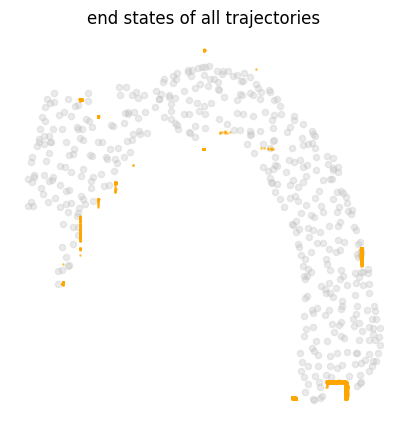

In [1161]:
newPaths = purge_end_state_stuttering(paths)
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in newPaths])
# sorted from long to short
order = np.argsort(traj_displacement)[::-1]
sorted_traj = newPaths[order]
traj_displacement=traj_displacement[order]

In [1162]:
path_clusters = list()
cell_clusters = list()
path_clusters, cell_clusters = clustering(
    path_clusters, cell_clusters, 
    sorted_traj, traj_displacement,
    0.4, 0, nkeep=-1)

cell_fate = cellPath(cell_embedding, cell_clusters)
cell_fate_major = np.argmax(cell_fate, axis=1)


cell_time_per_cluster = [cell_time_projection_cluster(cell_embedding, path_clusters[i][0], i, cell_fate_major) 
                         for i in np.unique(cell_fate_major)]

Currently  0 clusters:	 4327 paths to be categorized
Currently  1 clusters:	 841 paths to be categorized
Currently  2 clusters:	 0 paths to be categorized


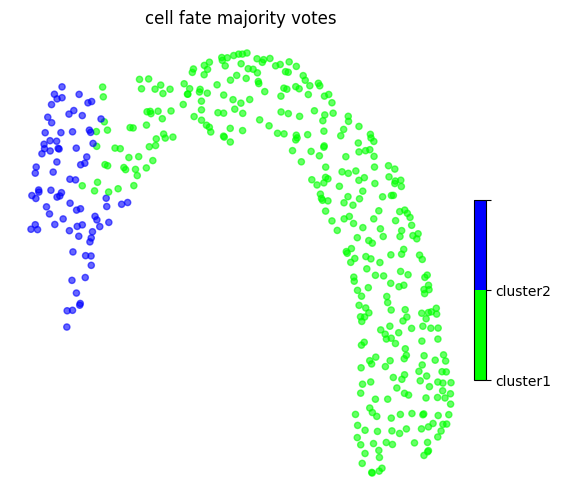

In [1166]:
def Plot_cell_cluster(cell_embedding, cell_clusters):
    n_clusters = len(cell_clusters)
    cmap = cm.get_cmap('brg_r', n_clusters) 
    cell_fate = cellPath(cell_embedding, cell_clusters)
    cell_fate_majority = cell_fate.argmax(axis=1)
    fig, ax1 = plt.subplots(figsize=(6, 6))
    img1=ax1.scatter(cell_embedding[:,0], cell_embedding[:,1], c=cell_fate_majority, s=20, alpha=0.6, cmap=cmap)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title("cell fate majority votes")
    ax1.axis("off")

    bounds = np.linspace(0, n_clusters, n_clusters+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax3 = fig.add_axes([0.9, 0.3, 0.02, 0.3])
    cb = mpl.colorbar.ColorbarBase(ax3, cmap=cmap, spacing='proportional', boundaries=bounds, norm=norm, format='%1i')
    labels = ["cluster"+str(i+1) for i in range(n_clusters)]
    labels.append("")
    cb.set_ticklabels(labels)
    
    plt.show()
Plot_cell_cluster(cell_embedding, cell_clusters)

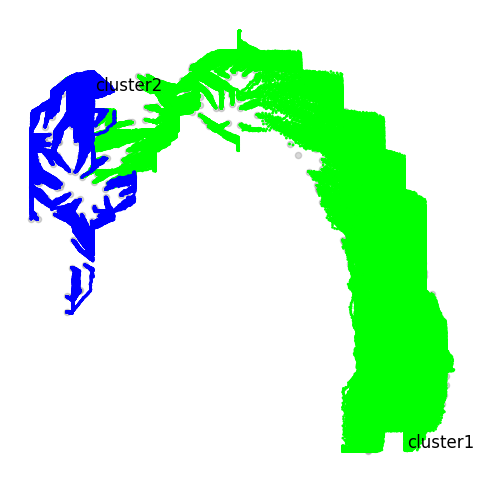

In [1167]:
def Plot_path_clusters(cell_embedding, clusters, n_clusters):    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(cell_embedding[:,0], cell_embedding[:,1], c='gray', s=20, alpha = 0.3)
    
    colors = iter(cm.brg_r(np.linspace(0, 1, n_clusters)))
    cluster_cnt = 0
    for cluster in clusters[:n_clusters]:
        cluster_cnt += 1
        cl = next(colors)
        plt.text(cluster[0][-1,0], cluster[0][-1,1], "cluster"+str(cluster_cnt), fontsize=12)
        for ipath in cluster:
            c = np.repeat(cl[None,:],len(ipath), axis=0)
            plt.scatter(np.array(ipath)[:,0], np.array(ipath)[:,1], s=1, c=c)
    plt.axis('off')
    plt.show()
    
Plot_path_clusters(cell_embedding, path_clusters, n_clusters=len(path_clusters))

The closest distance is  0.09630964871536425
Between dot 370  from refPath1 and dot 0 from refPath2.


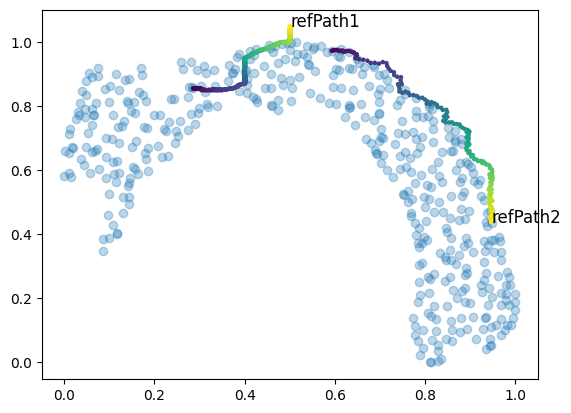

(0.09630964871536425, (370, 0))

In [1115]:
def closest_distance_between_two_paths(path1, path2):
    '''
    returns the closest distance and the closest cells.
    '''
   
    if path1.size and path2.size:
        temp = path1 - path2[:, None]
        A = np.sum(temp**2, axis=2)
        pair = np.unravel_index(np.argmin(A), A.shape)
        print("The closest distance is ", np.sqrt(A[pair]))
        print("Between dot", pair[1], " from refPath1 and dot", pair[0], "from refPath2.")
        plt.scatter(cell_embedding[:,0], cell_embedding[:,1], alpha = 0.3)
        plt.scatter(path1[:,0], path1[:,1], c=range(len(path1)), s=5)
        plt.text(path1[-1,0], path1[-1,1], "refPath"+str(1), fontsize=12)
        plt.text(path2[-1,0], path2[-1,1], "refPath"+str(2), fontsize=12)        
        plt.scatter(path2[:,0], path2[:,1], c=range(len(path2)), s=5)
        plt.show()
        return np.sqrt(A[pair]), pair[::-1]
    else:
        return np.Inf,(np.nan,np.nan)
    
    
closest_distance_between_two_paths(newPaths[50], newPaths[100])


In [1171]:
def progressive_cell_time_assignment_intracluster(
    unresolved_cell_time_cluster, cluster, sorted_refPaths, cell_fate,
    cell_embedding, vel, grid_density, 
    MAX_ZERO_TIME_CELLS = 10):
    '''
    
    Recursive function to consolidate cell time within a cluster.
    
    
    Parameters
    ----------
    unresolved_cell_time_cluster: list
        a list of dictionary {cellID : time}
        cellIDs and corresponding unresolved time for a specific cluster
    
    sorted_refPaths: list
        a list of paths in the cluster ordered from longest to shortest in displacement. 
        
    cell_embedding, vel, grid_density: a set of parameters for the diffusion simulations.
    
    Return
    ------
    resolved_cell_time_cluster: list
        a list of dictionaries {cellID : time} 
    
    sorted_refPaths: list
        a list of longest trajectories used for cell time projection
    '''
    
    ZERO = 0

    # Let's not edit the original dictionary
    #resolved_cell_time_cluster = copy.deepcopy(unresolved_cell_time_cluster)
    
    zero_time_cells = [cellid for cellid, celltime in unresolved_cell_time_cluster[cluster].items() if celltime <= ZERO]
    if len(zero_time_cells) < MAX_ZERO_TIME_CELLS:
        return unresolved_cell_time_cluster, sorted_refPaths
    
    # get subsampled cell embedding
    sub_embedding = cell_embedding[zero_time_cells]

    # get subsampled density matrix
    sub_grid_density = np.zeros_like(grid_density)
    for cell in zero_time_cells:
        i = tuple(cell_grid_idx[cell])
        sub_grid_density[i] = grid_density[i]
    
    # sanity check
    plt.rcParams['figure.figsize']=(20,6)
    plt.subplot(131)
    plt.scatter(cell_embedding[:,0], cell_embedding[:,1], alpha = 0.3)
    plt.scatter(sub_embedding[:,0], sub_embedding[:,1], c='k')
    plt.title("spread of the zero time cells")
    plt.subplot(132)
    plt.imshow(grid_density.T, interpolation=None, origin='lower',cmap="Greys")
    plt.title("global cell density")
    plt.subplot(133)
    plt.imshow(sub_grid_density.T, interpolation=None, origin='lower',cmap="Greys")
    plt.title("cell density for generating new trajectories")
    plt.show()
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    # generating new trajectories for the zero-time cells
    print("Sampling new trajectories for zero-time cells in cluster ", cluster, "  ...")
    sub_traj=run_diffusion(cell_embedding, vel=vel, grid_density=sub_grid_density, 
                           dt=0.01, t_total=10000, eps=1e-5, 
                           off_cell_init=False, init_cell=zero_time_cells, 
                           n_repeats = 10, n_jobs = mp.cpu_count()-1)
    
    # finding the longest trajectory
    newPaths = purge_end_state_stuttering(sub_traj, PLOT=False)
    traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in newPaths])
    order = np.argsort(traj_displacement)[::-1]
    sorted_traj = newPaths[order]
    traj_displacement=traj_displacement[order]

    # add the longest trajectory belonging to the zero-time cells to the ref paths.
    ref_path = sorted_traj[0]
    
    # re-assign time for zero time cells
    sub_cell_time = cell_time_projection_cluster(cell_embedding, ref_path, cluster, cell_fate)

    # consolidate 
    dist, (dotA, dotB) = closest_distance_between_two_paths(ref_path, sorted_refPaths[-1])
    
    print("now the cell time is updated for cluster: ", cluster)
    print("shifting ref_path2 by time ", dotA-dotB)
    #print(unresolved_cell_time_cluster[cluster])


    for cell in unresolved_cell_time_cluster[cluster]:
        unresolved_cell_time_cluster[cluster][cell] = sub_cell_time[cell] if cell in zero_time_cells else \
             unresolved_cell_time_cluster[cluster][cell] - dotB + dotA

    #print(unresolved_cell_time_cluster[cluster])
    sorted_refPaths.append(ref_path)
    #Plot_path_clusters(cell_embedding, [sorted_refPaths], n_clusters=1)
    
    return progressive_cell_time_assignment_intracluster(
        unresolved_cell_time_cluster, cluster, sorted_refPaths, cell_fate,
        cell_embedding, vel, grid_density, MAX_ZERO_TIME_CELLS = 10)

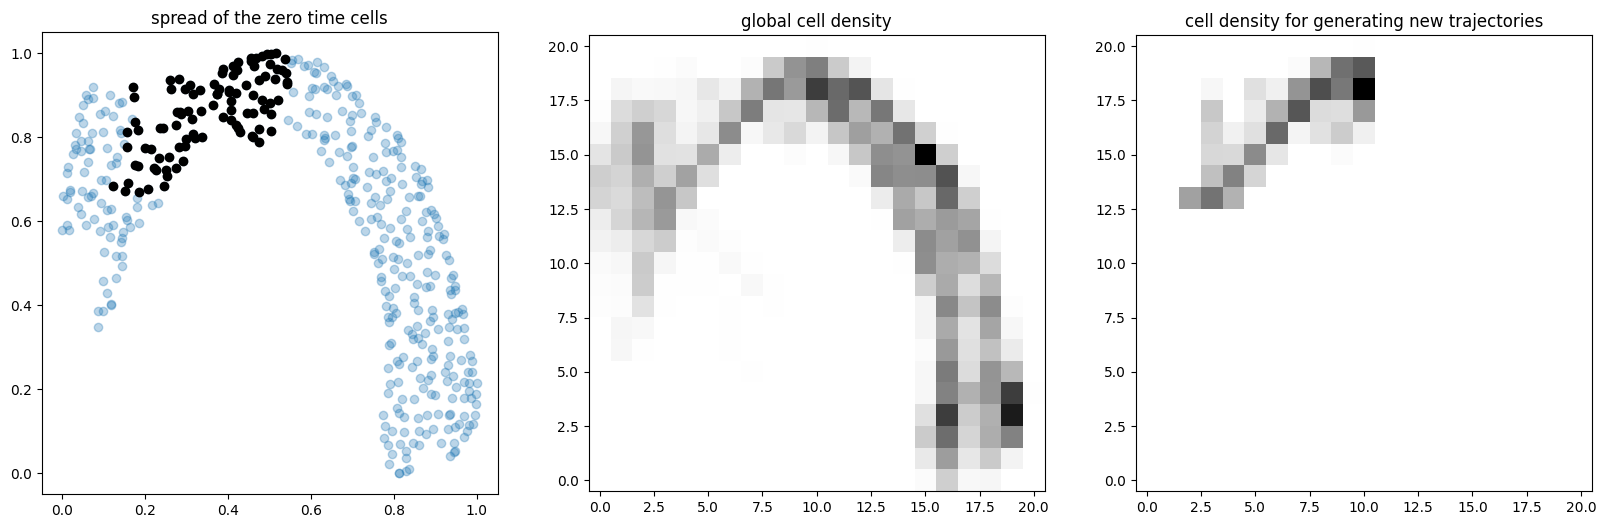

Sampling new trajectories for zero-time cells in cluster  0   ...
The closest distance is  0.040052221768189934
Between dot 949  from refPath1 and dot 0 from refPath2.


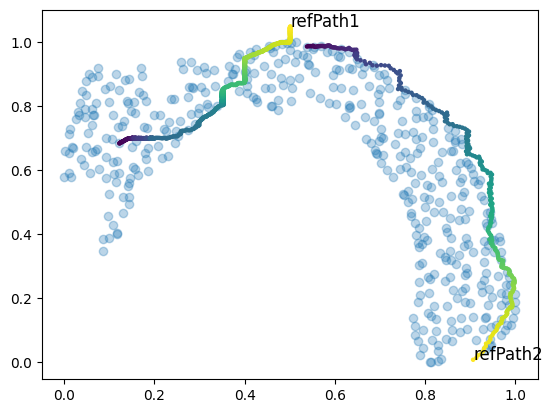

now the cell time is updated for cluster:  0
shifting ref_path2 by time  949


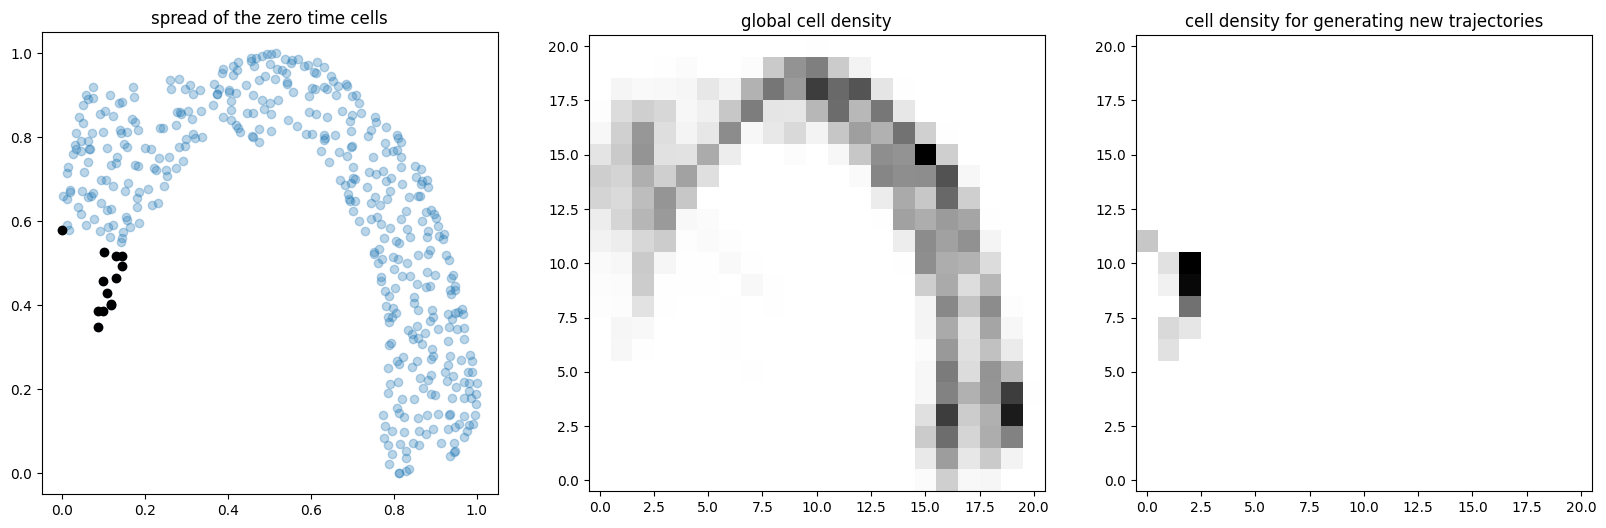

Sampling new trajectories for zero-time cells in cluster  1   ...
The closest distance is  0.11353929414690583
Between dot 0  from refPath1 and dot 0 from refPath2.


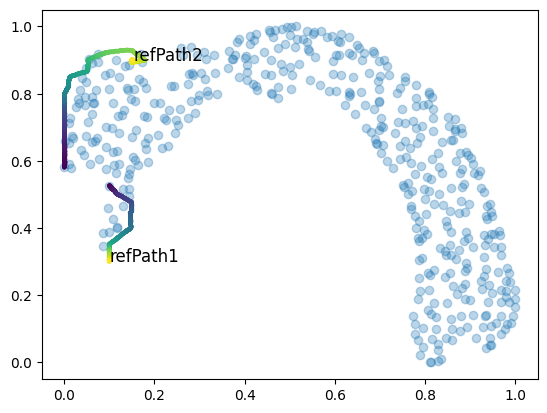

now the cell time is updated for cluster:  1
shifting ref_path2 by time  0


In [1172]:
cell_time_per_cluster=[cell_time_projection_cluster(cell_embedding, path_clusters[i][0], i, cell_fate_major) 
                         for i in np.unique(cell_fate_major)]

# Caution: inplace modifying cell_time_per_cluster.
n_clusters = len(path_clusters)
for cluster_number in range(n_clusters):
    cell_time_per_cluster, refPaths = progressive_cell_time_assignment_intracluster(
        cell_time_per_cluster, cluster_number, [path_clusters[cluster_number][0]], 
        cell_fate_major, cell_embedding, vel_mesh, grid_density, MAX_ZERO_TIME_CELLS = 10)

In [1490]:
def Cell_time_assignment_intercluster(
    unresolved_cell_time, cell_fate, cell_embedding, tau = 0.05):
    '''
    
    Recursive function to consolidate cell time between clusters. 
    
    Find an intersection between cells from two clusters and reconsolidate their time.
    
    Assumption: No cyclic behavior between clusters. 
    
    
    Parameters
    ----------
    unresolved_cell_time: list
        a list of dictionary {cellID : time}
        cellIDs and corresponding unresolved time for all cells.
    
    cell_fate: np.ndarray
        an array of cluster numbers which each cell belongs to.
    
    Return
    ------
    resolved_cell_time_cluster: list
        a list of dictionaries {cellID : time} 
    
    '''
    

    cutoff = overlap_intra_cluster(cell_embedding, cell_fate, tau)
    clusterIDs = np.unique(cell_fate)
    
    # Creating a graph: node <- clusterID, edge & weigth <- absolute shift time
    G = nx.Graph()
    G.add_nodes_from(cluster0_IDs)
    
    for i,j in itertools.combinations(clusterIDs, 2):
        shiftT = cluster_overlap_time(cell_embedding, cell_fate_major, cell_time_per_cluster, i, j, cutoff)
        if shiftT:
            G.add_edge(i, j, weight = np.abs(shiftT))
    
    if not nx.is_forest(G):
        print("There exists a cycle in the cluster graph. We cannot consilidate cell time in this case.")
        return unresolved_cell_time
    
    # reconsolidate 
    #dist, (dotA, dotB) = closest_distance_between_two_paths(ref_path, sorted_refPaths[-1])
    
    #print("now the cell time is updated for cluster: ", cluster)
    #print("shifting ref_path2 by time ", dotA-dotB)
    #print(unresolved_cell_time_cluster[cluster])


    #for cell in unresolved_cell_time_cluster[cluster]:
        #unresolved_cell_time_cluster[cluster][cell] = sub_cell_time[cell] if cell in zero_time_cells else \
             #unresolved_cell_time_cluster[cluster][cell] - dotB + dotA

    #print(unresolved_cell_time_cluster[cluster])
    #sorted_refPaths.append(ref_path)
    #Plot_path_clusters(cell_embedding, [sorted_refPaths], n_clusters=1)
    
    return unresolved_cell_time

In [1670]:
def Plot_celltime_clusters(cell_time_per_cluster, rep_paths, embedding):
    longest_paths = [ipath[0] for ipath in rep_paths]
    fig, ax = plt.subplots(figsize=(6, 6))

    n_paths = len(longest_paths)
    #cmap = cm.get_cmap('rainbow_r', n_paths)
    cmap = ['viridis','viridis']

    for i in range(n_paths):
        #print("path ", i)
        # create colormap for each path
        #colormap = ListedColormap(np.linspace(0.0, cmap(i), 256))
        colormap = cmap[i]
        cell_index = list(cell_time_per_cluster[i].keys())
        cell_time = list(cell_time_per_cluster[i].values())
        cells = embedding[cell_index]
        #pos = np.mean(cells, axis=0)
        plt.scatter(cells[:,0], cells[:,1], c=cell_time, s=20, cmap = colormap)
        #plt.colorbar()
        #plt.text(pos[0], pos[1], "cluster"+str(i+1), fontsize=12)
        ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.show()
#Plot_celltime_clusters(cell_time_per_cluster, path_clusters, cell_embedding)

Plotting estimated pseudotime for all cells ...


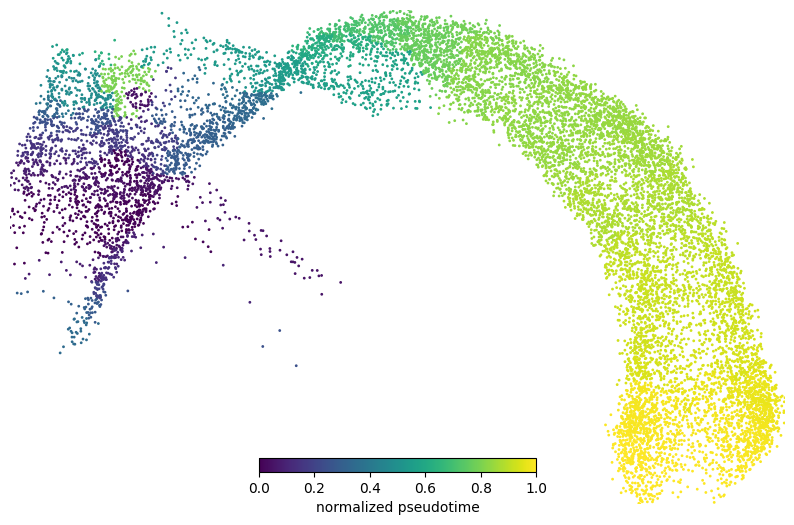

In [1674]:
# combine cell time from clusters
def combine_clusters(cell_time_per_cluster):
    cell_time = dict()
    for d in cell_time_per_cluster:
        for k, v in d.items():
            cell_time[k] = v
    return cell_time

def interpolate_all_cell_time(cell_time, all_cell_embedding, sampling_ixs, step = step):
    x = all_cell_embedding[sampling_ixs,0]
    y = all_cell_embedding[sampling_ixs,1]
    f = cell_time
    
    xx = np.linspace(min(x), max(x), step[0]+1)
    yy = np.linspace(min(y), max(y), step[1]+1)
    xx, yy = np.meshgrid(xx, yy)
    
    points = np.transpose(np.vstack((x, y)))
    f_interp = interpolate.griddata(points, f, (xx, yy), method='nearest')
    cell_time_all = list()
    for cell_coord in embedding:
        gd = discretize(cell_coord, xmin=(min(x), min(y)), xmax=(max(x),max(y)), steps=step, capping = True)[0]
        cell_time_all.append(f_interp[gd[1], gd[0]])
    cell_time_all = np.array(cell_time_all)
    cell_time_all = cell_time_all/np.max(cell_time_all)
    
    print("Plotting estimated pseudotime for all cells ...")
    fig, ax = plt.subplots(figsize=(10,6))
    im = plt.scatter(X, Y, c=cell_time_all, alpha = 1, s = 1)

    plt.xlim([min(x), max(x)])
    plt.ylim([min(y), max(y)])
    #plt.scatter(x, y, c=f, alpha = 0.2, s = 5, edgecolors='black')
    cax = plt.colorbar(im,fraction=0.03, pad=-0.1, location='bottom')
    cax.set_label('normalized pseudotime')
    #plt.title('pseudotime: gastrulation')
    plt.axis('off')
    plt.show()
    
    return cell_time_all
    
    
ordered_cell_time = np.array([cell_time[cell] for cell in sorted(cell_time.keys())])

cell_time_all = interpolate_all_cell_time(ordered_cell_time, embedding, sampling_ixs, step)

#Plot_celltime_clusters([cell_time], [path_clusters[0]], cell_embedding)

In [1697]:
data = np.vstack((np.array(list(range(len(embedding))), dtype=int), cell_time_all)).T
pd.DataFrame(data).to_csv('cell_time.Gastrulation.csv', index=None, header = ['index','time'], float_format='%g')

In [1676]:
# export data
def export_cell_time(load_cellDancer, cell_time, filename):
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]

    if len(load_cellDancer) == len(gene_names) * len(cell_time):
        load_cellDancer['time'] = np.tile(cell_time,len(gene_names))
        load_cellDancer.to_csv(filename, index=None)

        
export_cell_time(load_cellDancer, cell_time_all, os.path.join(output_path, "detail_cell_time.Gastrulation.csv"))

In [ ]:
def overlap_intra_cluster(cell_embedding, cell_fate, quant):
    cutoff = list()
    for cluster_ID in np.unique(cell_fate):
        cell_cluster = cell_embedding[cell_fate == cluster_ID]
        temp1 = cell_cluster - cell_cluster[:,None]
        temp2 = np.linalg.norm(temp1, axis=-1)
        
        # drop the self distances
        temp3 = temp2[~np.eye(temp2.shape[0], dtype=bool)]
        cutoff.append((np.quantile(temp2, quant)))
    return max(cutoff)

def find_uniq_cell_pairs(pairs, distances):
    '''
    pairs: tuple (np.where format) 
    distances: 1d np.array <- pairwise distance 
    '''
    
    order = np.argsort(distances)
    ordered_pairs = np.array(pairs).T[order]

    fbd_cell_a = list()
    fbd_cell_b = list()
    uniq_pair = list()
    for pair in ordered_pairs:
        if pair[0] in fbd_cell_a or pair[1] in fbd_cell_b:
            continue
        else:
            uniq_pair.append(pair)
            fbd_cell_a.append(pair[0])
            fbd_cell_b.append(pair[1])
    return np.array(uniq_pair)

def cluster_overlap_time(cell_embedding, cell_fate, cell_time_per_cluster, cluster0_ID, cluster1_ID, 
                         cutoff, peak_mode='most_frequent'):
    '''
    returns the indices of overlapping cells in pairs.
    
    TODO: There could be cases that we cannot handle. 
    [e.g. multiple significant peaks]
    '''
    
    cluster0_cellID = np.where(cell_fate_major == cluster0_ID)[0]
    cluster1_cellID = np.where(cell_fate_major == cluster1_ID)[0]

    cell_cluster0 = cell_embedding[cluster0_cellID]
    cell_cluster1 = cell_embedding[cluster1_cellID]
    if cell_cluster0.size and cell_cluster1.size:
        temp1 = cell_cluster0 - cell_cluster1[:, None]
        temp2 = np.linalg.norm(temp1, axis=-1)
        closePairs = np.where(temp2 < cutoff)
        
        if len(closePairs) == 0:
            print("No close cells between clusters\t", (cluster0_ID, cluster1_ID))
            return None
        #print("\ncells in cluster0 \n", cluster0_cellID[closePairs[1]])
        #print("\ncells in cluster1 \n", cluster1_cellID[closePairs[0]])
        
        # 1 cell can pair maximum 1 cell.
        idx = find_uniq_cell_pairs(closePairs, temp2[closePairs])
        # after swapping, now:
        # first column -> cluster0
        # second column -> cluster1
        idx[:,[1,0]] = idx[:,[0,1]]
    
        print(idx)

        
        plt.scatter(cell_embedding[:,0], cell_embedding[:,1], s=5, alpha=0.3)
        plt.scatter(cell_cluster0[idx[:,0]][:,0], cell_cluster0[idx[:,0]][:,1])
        plt.scatter(cell_cluster1[idx[:,1]][:,0], cell_cluster1[idx[:,1]][:,1])
    
        deltaT = [cell_time_per_cluster[0][cluster0_cellID[pair[0]]]-
                  cell_time_per_cluster[1][cluster1_cellID[pair[1]]] 
                  for pair in idx]
        freq, delta = np.histogram(deltaT)
        plt.show()

        plt.hist(deltaT)
        #print("\nfrequency is \n", freq)
        #print("\ndelta T is \n", delta)
        
        if peak_mode in ['most_frequent']:
            shiftT = delta[np.argmax(freq)]
        elif peak_mode in ['least_shift']:
            # TODO
            print("To be implemented.")
            return None
        #print("Need to shift cluster1 time by ", shiftT)
        
        return shiftT

cutoff = overlap_intra_cluster(cell_embedding, cell_fate_major, quant=0.1)

cluster_overlap_time(cell_embedding, cell_fate_major, cell_time_per_cluster, 0, 1, cutoff)